#### This Notebook will <li> prepare the data for the supervised machine learning algorithms <li> add length of text comments as a feature <li> draw the histograms of length for Fake or Not Fake labels <li> create the bag of words <li> import 8 classifiers <li> create train and test datasets for the combinations of the 3 different features <li> run and compare the scores from the classifiers for 3 different features <li> plot the different scores <li> print the confusion matrix from the best looking score

In [43]:
#import packages and visualization tools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix,classification_report
import math
%matplotlib inline

Import the labeled dataset and prepare it for NLP using several different models

In [2]:
#import classifed data set 500 labeled rows 
df = pd.read_csv('df_random500.csv',encoding='latin-1')

# rename text_data column
df=df.rename(columns = {'text_data':'text'})

# rename fake date to label column
df=df.rename(columns = {'Fake':'label'})

#remove float entries from text column - convert null to ""
df['text'] = df['text'].fillna('')

# add length
df['length'] = df['text'].apply(len)

Inspect the features to be used from the sample dataframe

In [154]:
df[['text','label','freq_time','length']].head()

,text,label,freq_time,length
0,Net neutrality should NOT be eradicated for th...,0,9,205
1,The unprecedented regulatory power the Obama A...,1,3,638
2,The FCC's Open Internet Rules (net neutrality ...,1,4,2311
3,The FCC's Open Internet Rules (net neutrality ...,1,5,2332
4,The FCC's Open Internet Rules (net neutrality ...,1,129286,2287


Compare the difference in comment text length of label '0', Fake, and label '1', Real

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C42E247048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002C42DD45BE0>], dtype=object)

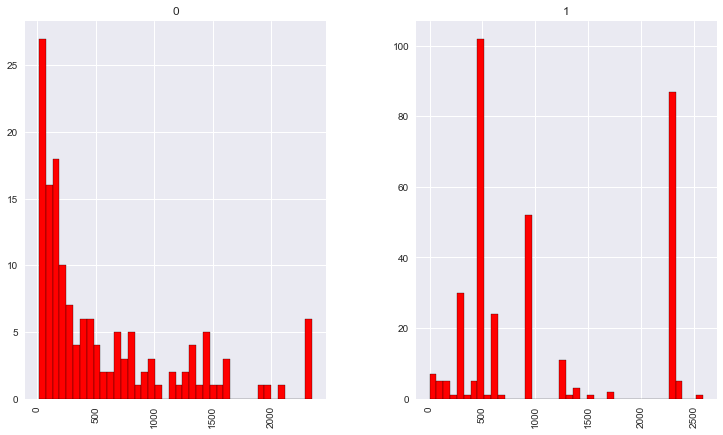

In [156]:
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()
plt.style.use('seaborn-bright')
df.hist(column='length', by='label', bins=40,figsize=(12,7), color='red')


In [7]:
text_feat = df['text'].copy()

Define the text cleaning / processing function

In [8]:
def text_process(text):
    """ 
    1 remove punctuation   
    2 remove stopwords, 
    3 return rejoined words
    """
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [9]:
print(text_feat.head(10))

0    Net neutrality should NOT be eradicated for th...
1    The unprecedented regulatory power the Obama A...
2    The FCC's Open Internet Rules (net neutrality ...
3    The FCC's Open Internet Rules (net neutrality ...
4    The FCC's Open Internet Rules (net neutrality ...
5    The Open Internet rules (net neutrality) are e...
6    I am writing in regard to the Commission?s wor...
7    The Open Internet rules (net neutrality) are e...
8    I strongly oppose Chairman Pai&apos;s proposal...
9    Hello, I want to say that giving the ability t...
Name: text, dtype: object


Transform the cleaned text to create a sparse matrix.

In [10]:
text_feat = text_feat.apply(text_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

Create the Bag of Words

In [11]:
#Bag of words creation
bow_transformer = CountVectorizer(analyzer=text_process).fit(text_feat)
comments_bow = bow_transformer.transform(text_feat)
#Normalization
tfidf_transformer = TfidfTransformer().fit(comments_bow)#fit to bag of words
comments_tfidf = tfidf_transformer.transform(comments_bow)#convert entire BOW corpus into TFIDF corpus

Split the dataset into Train and Test

In [12]:
#Select Training and Test data 
features_train, features_test, labels_train, labels_test = train_test_split(comments_tfidf, df['label'], test_size=0.4, random_state=111)

Import a host of classifiers to model with.

In [13]:
#Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

Instatiate the classifiers with meta parameters

In [18]:
#Assign the classifiers 
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=5)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)

Create the classifiers dictionary to iterate through.

In [19]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc}

In [20]:
def train_classifier(clf, feature_train, labels_train):
    """create the classfier feeder to fit the features and labels"""
    clf.fit(feature_train, labels_train)

In [21]:
def predict_labels(clf, features):
    """predicted values from the features matrix"""
    return (clf.predict(features))

Iterate through the classifier items to train, predict and append results to a display dataframe.

In [22]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [94]:
df_result = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df_result

,Score
SVC,0.728643
KN,0.869347
NB,0.517588
DT,0.859296
LR,0.864322
RF,0.884422
AdaBoost,0.864322
BgC,0.884422


Compare the results:

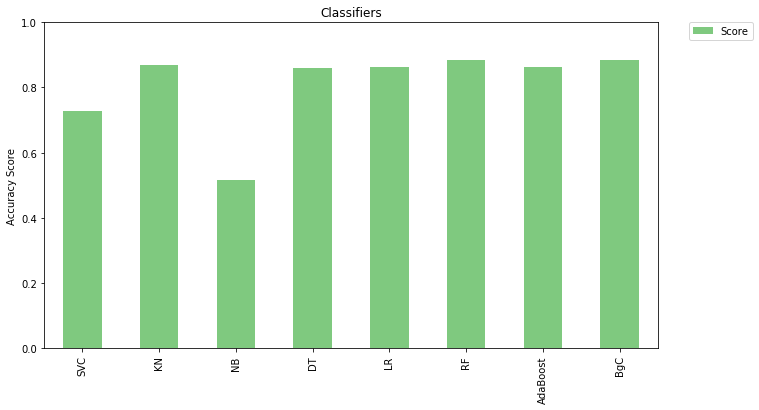

In [95]:
df_result.plot(kind='bar', ylim=(0.0,1.0), figsize=(11,6), align='center', colormap="Accent") #change ylim to 0.5 for detail..
plt.xticks(np.arange(8), df_result.index)
plt.ylabel('Accuracy Score')
plt.title('Classifiers')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Add feature of Submission Time Frequency:

In [96]:
#Submission Time Frequency
tf = df['freq_time'].as_matrix()

Add feature Length of Comment Text:

In [97]:
#Comment Text Length
lf = df['length'].as_matrix()

Combine Length of Comment Text & Freqnuecy of Submission into a 2 column vertical array:

In [98]:
doublestack = np.column_stack((tf,lf))

Create 3 matrices that are the combinations of the 2 additional features we will add to the TCDIF.

In [99]:
newfeat1 = np.column_stack((comments_tfidf.todense(),lf[:, None]))
newfeat2 = np.column_stack((comments_tfidf.todense(),tf[:, None]))
newfeat3 = np.column_stack((comments_tfidf.todense(),doublestack))

Create training/test set with TFIDF and Comment Length.

In [100]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat1, df['label'], test_size=0.4, random_state=111)

Iterate through the classifier items to train, predict and append results to a display dataframe.

In [101]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [102]:
#Create Dataframe of predicted accuracy scores
df1 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Comment Length'])
df_result = pd.concat([df_result,df1],axis=1)
df_result

,Score,Comment Length
SVC,0.728643,0.728643
KN,0.869347,0.834171
NB,0.517588,0.708543
DT,0.859296,0.849246
LR,0.864322,0.804020
RF,0.884422,0.894472
AdaBoost,0.864322,0.869347
BgC,0.884422,0.859296


Compare the results:

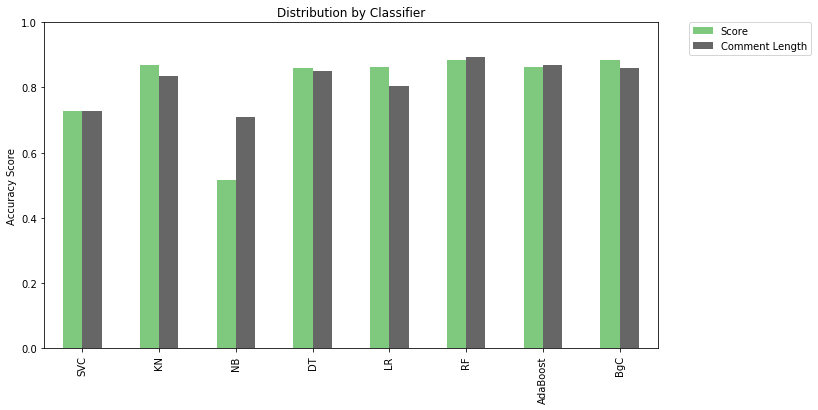

In [103]:
#Plot Dataframe of predicted accuracy scores
df_result.plot(kind='bar', ylim=(0.0,1.0), figsize=(11,6), align='center', colormap="Accent") #change ylim to 0.9 for detail..
plt.xticks(np.arange(8), df_result.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Create training/test set with TFIDF and Submissions per Second

In [104]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat2, df['label'], test_size=0.4, random_state=111)

Iterate through the classifier items to train, predict and append results to a display dataframe.

In [105]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [106]:
df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Submission Frequency'])
df_result = pd.concat([df_result,df2],axis=1)
df_result

,Score,Comment Length,Submission Frequency
SVC,0.728643,0.728643,0.728643
KN,0.869347,0.834171,0.819095
NB,0.517588,0.708543,0.527638
DT,0.859296,0.849246,0.874372
LR,0.864322,0.804020,0.844221
RF,0.884422,0.894472,0.889447
AdaBoost,0.864322,0.869347,0.884422
BgC,0.884422,0.859296,0.879397


Compare the results:

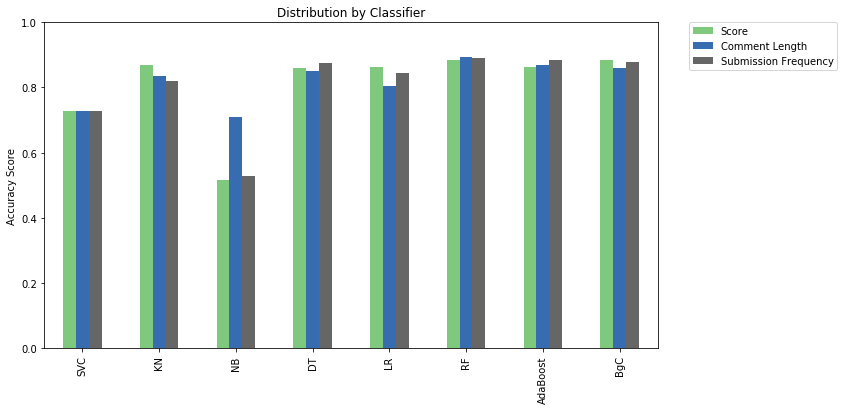

In [107]:
df_result.plot(kind='bar', ylim=(0.0,1.0), figsize=(11,6), align='center', colormap="Accent") #change ylim to 0.9 for detail..
plt.xticks(np.arange(8), df_result.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Create training/test set with TFIDF, Comment Length and Submissions per Second

In [108]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat3, df['label'], test_size=0.4, random_state=111)

Iterate through the classifier items to train, predict and append results to a display dataframe.

In [109]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [110]:
df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Length & Frequency'])
df_result = pd.concat([df_result,df3],axis=1)
df_result

,Score,Comment Length,Submission Frequency,Length & Frequency
SVC,0.728643,0.728643,0.728643,0.728643
KN,0.869347,0.834171,0.819095,0.869347
NB,0.517588,0.708543,0.527638,0.517588
DT,0.859296,0.849246,0.874372,0.859296
LR,0.864322,0.804020,0.844221,0.859296
RF,0.884422,0.894472,0.889447,0.884422
AdaBoost,0.864322,0.869347,0.884422,0.864322
BgC,0.884422,0.859296,0.879397,0.884422


Compare the results:

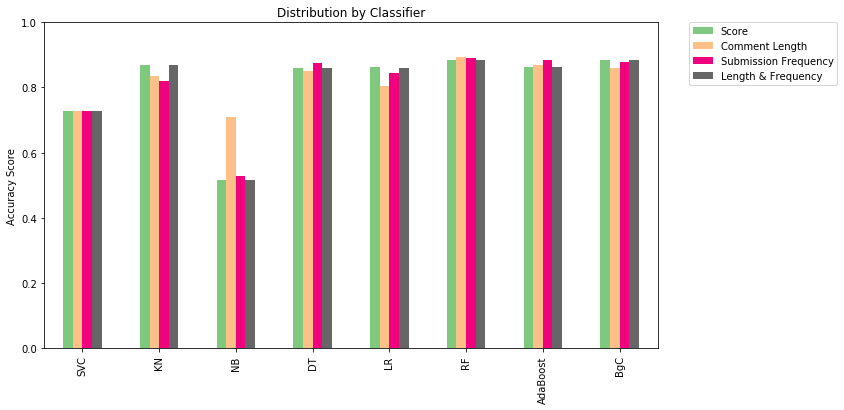

In [111]:
df_result.plot(kind='bar', ylim=(0.0,1.0), figsize=(11,6), align='center', colormap="Accent") #change ylim to 0.9 for detail..
plt.xticks(np.arange(8), df_result.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The highest group of accuracy scores is coming from the Random Forest classifier. With the TCDIF, the addition of either Comment Length or Submission Frequency gives slight improvement. The addition of both features to the TCDIF yealds little improvement however.

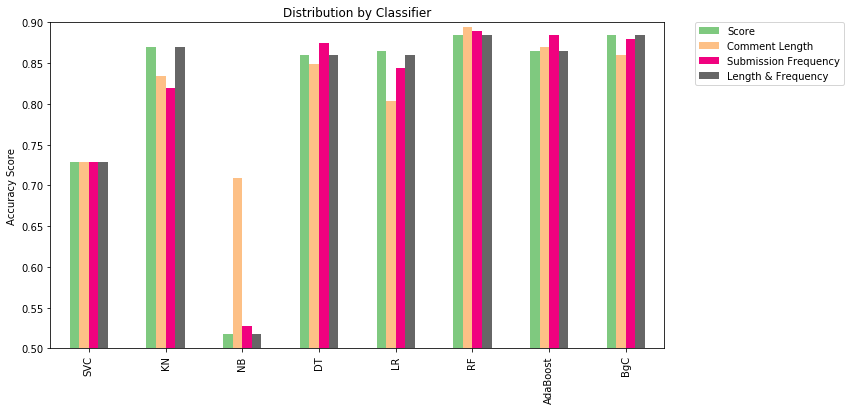

In [115]:
df_result.plot(kind='bar', ylim=(0.5,0.9), figsize=(11,6), align='center', colormap="Accent") #change ylim to 0.4 for detail..
plt.xticks(np.arange(8), df_result.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Create the confusion Matrix for the TFIDF & Length.

In [116]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat1, df['label'], test_size=0.4, random_state=111)

In [122]:
#for k,v in clfs.items():
train_classifier(rfc, features_train, labels_train)
pred = predict_labels(rfc,features_test)
#    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [123]:
#Print Confusion Matrix for RF classifier : TFIDF & Comment Length
print ('\nClassification Report: RFC\n', classification_report(labels_test,pred))
confusion_matrix_graph = confusion_matrix(labels_test,pred)


Classification Report: RFC
              precision    recall  f1-score   support

          0       0.75      0.93      0.83        54
          1       0.97      0.88      0.92       145

avg / total       0.91      0.89      0.90       199

